In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import math
import csv

# **导入数据**

In [2]:
path =  'hw1_data/train.csv'
data = pd.read_csv(path)
data[data == 'NR'] = 0 #替换非数字为0
raw_data = data.iloc[:, 3:].to_numpy()

In [3]:
raw_data.shape

(4320, 24)

# **按月重新分组数据**
將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。
![圖片說明](hw1_data/换形状1.png)
![圖片說明](hw1_data/换形状2.png)

In [4]:
month_data = {} #一个月一个矩阵，month_data是一个数组
for month in range(12):  #year 2014 has 12 months
    sample = np.empty([18,480])
    for day in range(20):  #20 days each month
        sample[:, 24*day : 24*(day+1)] = raw_data[18*(20*month+day): 18*(20*month+day+1) , :]
    month_data[month] = sample
month_data[0].shape #一月的数据形状

(18, 480)

# **按小时分组**

利用前9个小时预测第10个小时
每個月會有 480hrs，每 9 小時形成一個 data（data之间有重叠,每个data偏移一列, 但每个月之间不重叠），每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)
![圖片說明](hw1_data/换形状3.png)

In [5]:
x = np.empty([471*12, 18*9], dtype = float)
y = np.empty([471*12,1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14: #每个月之间不重叠，所以每个月最后一日的9个小时不用重复
                continue #跳出循环
            #再次改矩阵形状，每行是9个小时
            x[month*471+day*24+hour, :] = month_data[month][:, day*24+hour : day*24+hour+9].reshape(1, -1) #.reshape(1, -1)将9行变成1行
            y[month*471+day*24+hour, 0] = month_data[month][9, day*24+hour+9]#第10个小时作为y，其中第9行为PM2.5值
print(x)
print(y)

[[14.  14.  14.  ...  2.   2.   0.5]
 [14.  14.  13.  ...  2.   0.5  0.3]
 [14.  13.  12.  ...  0.5  0.3  0.8]
 ...
 [17.  18.  19.  ...  1.1  1.4  1.3]
 [18.  19.  18.  ...  1.4  1.3  1.6]
 [19.  18.  17.  ...  1.3  1.6  1.8]]
[[30.]
 [41.]
 [44.]
 ...
 [17.]
 [24.]
 [29.]]


In [6]:
print(x.shape)
print(y.shape)

(5652, 162)
(5652, 1)


# **数据归一化**

In [7]:
mean_x = np.mean(x, axis = 0) #每列的平均值
std_x = np.std(x, axis = 0) #每列的标准差
for i in range(len(x)): #x的行数
    for j in range(len(x[0])): #x的列数
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j] #归一化
x

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

Split Training Data Into "train_set" and "validation_set" 生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [8]:
x_train_set = x[: math.floor(len(x) * 0.8), :]#取前面80%
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]#取后面20%
y_validation = y[math.floor(len(y) * 0.8): , :]
print(len(x_train_set))
print(len(y_train_set))
print(len(x_validation))
print(len(y_validation))

4521
4521
1131
1131


In [9]:
x_validation.shape

(1131, 162)

# **训练**
![圖片說明](hw1_data/训练1.png)
![圖片說明](hw1_data/训练2.png)
![圖片說明](hw1_data/训练3.png)
(和上圖不同處: 下面的 code 採用 Root Mean Square Error 均方根差 $ RMSE = \sqrt{\sum_{i=0}^{N}{}(f(x_i) - Y_i)^2 \over N} $)

因為常數項的存在，所以 x的维度 (dim) 需要多加，一列全部为1

adagrad （Adaptive Gradient）自适应学习率: 为不同的变量提供不同的学习率,对于某些变量，已经优化到了极小值附近，但是有的变量仍然在梯度很大的地方，这时候一个统一的全局学习率是可能出现问题的。如果学习率太小，则梯度很大的变量会收敛很慢，如果学习率太大，已经趋于收敛的变量可能会不稳定  $$ w = w - {learning\_rate \times {gradient \over {\sqrt{adagrad + eps}}}} $$

eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

loss函数 $$ lose = \sqrt{\sum_{i=0}^{471\times 12}{}(x_{i}w - y_i)^2 \over 471\times 12} $$

loss的w偏导数 $$ lose'_w = 2(xw - y)\dot x $$

In [10]:
dim = 18 * 9 + 1
w = np.zeros([dim, 1]) #权重矩阵
x_train_set = np.concatenate((np.ones([4521, 1]), x_train_set), axis = 1).astype(float) #在x前面加1列全部为1，.concatenate是拼接
learning_rate = 100
iter_time = 10000 #学习次数
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set, w) - y_train_set, 2))/4521) #算loss
    if(t%100==0): #输出loss
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x_train_set.transpose(), np.dot(x_train_set, w) - y_train_set) #偏导数
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
#np.save('weight.npy', w)
w

0:27.239591682144457
100:22.72397574459953
200:10.427772652266508
300:7.6358247722046615
400:6.849878685598298
500:6.518567463859375
600:6.325643080539458
700:6.1943518687643575
800:6.099081161908109
900:6.027838242824769
1000:5.973549167998369
1100:5.931540154046941
1200:5.8985669337452915
1300:5.872325230488117
1400:5.8511568464138906
1500:5.833856999555529
1600:5.819542803399005
1700:5.807561707356182
1800:5.797427062209042
1900:5.7887724504039415
2000:5.781319137238359
2100:5.774852760542453
2200:5.769206558969975
2300:5.764249247898767
2400:5.759876211547741
2500:5.756003070001555
2600:5.752560953253552
2700:5.749493006853912
2800:5.746751789731569
2900:5.744297321125586
3000:5.742095602045916
3100:5.740117485479364
3200:5.738337804411614
3300:5.736734691695407
3400:5.735289043713197
3500:5.733984092680351
3600:5.7328050617448225
3700:5.731738883779949
3800:5.730773969663582
3900:5.729900015406947
4000:5.72910784011028
4100:5.728389248644431
4200:5.727736914378395
4300:5.727144278

array([[ 2.15188102e+01],
       [ 2.29630641e-01],
       [-4.24373563e-01],
       [ 8.96910085e-01],
       [-1.79863767e+00],
       [-2.66325649e-01],
       [ 7.75277044e-01],
       [-7.60351420e-01],
       [-1.41055781e+00],
       [ 2.53431971e+00],
       [-3.33529637e-01],
       [ 1.67490031e-01],
       [-1.85923731e-02],
       [-2.39127957e-02],
       [-7.92909962e-02],
       [-7.35963112e-02],
       [-3.89663831e-02],
       [ 2.12579562e-01],
       [ 3.39928885e-01],
       [ 5.85164837e-02],
       [-4.38662767e-02],
       [ 6.05894935e-02],
       [-1.53410785e-01],
       [ 1.43266636e-01],
       [-4.30301375e-02],
       [-1.71534413e-01],
       [ 7.54872285e-02],
       [ 3.65255644e-01],
       [-2.64250464e-01],
       [ 3.36518800e-01],
       [-3.90131389e-01],
       [ 2.81821183e-01],
       [ 2.75806913e-01],
       [-5.31182335e-01],
       [ 2.68663281e-01],
       [ 1.60437275e-01],
       [ 3.07789991e-02],
       [ 2.31831875e-01],
       [ 1.7

# **验证**

In [11]:
#代入验证数据集
x_validation = np.concatenate((np.ones([1131, 1]), x_validation), axis = 1).astype(float)
yv = np.dot(x_validation, w)

In [12]:
#算误差百分比
erro_rate = (yv - y_validation)/(y_validation+eps) *100
erro_rate

array([[ 10.18745528],
       [-34.91780265],
       [-12.13803154],
       ...,
       [ 21.17719264],
       [ -9.90052431],
       [-13.35090785]])

In [16]:
x_axis = []
for i in range(1,1132):
    x_axis.append(i)

count    1.131000e+03
mean     1.832765e+11
std      1.147116e+12
min      6.486224e-02
25%      9.549249e+00
50%      2.076619e+01
75%      4.513099e+01
max      2.012780e+13
Name: 0, dtype: float64


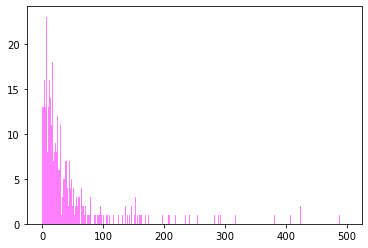

In [17]:
#误差百分比分布
erro_rate1 = pd.DataFrame(erro_rate, index = x_axis)
print(abs(erro_rate1[0]).describe())
#误差百分比分布图
bins=np.arange(0.001,500,1)#设置连续的边界值
plt.hist(erro_rate1[0],bins,color='fuchsia',alpha=0.5)#alpha设置透明度，0为完全透明
plt.show()

# **Testing**
載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [60]:
#载入测试数据集
path =  'hw1_data/test.csv'
data = pd.read_csv(path, header = None)
data[data == 'NR'] = 0 #替换非数字为0
test_data = data.iloc[:, 2:].to_numpy()

In [61]:
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240): #改好
    test_x[i, :] = test_data[18*i :18*(i+1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

array([[ 1.        , -0.24447681, -0.24545919, ..., -0.67065391,
        -1.04594393,  0.07797893],
       [ 1.        , -1.35825331, -1.51789368, ...,  0.17279117,
        -0.10906991, -0.48454426],
       [ 1.        ,  1.5057434 ,  1.34508393, ..., -1.32666675,
        -1.04594393, -0.57829812],
       ...,
       [ 1.        ,  0.3919669 ,  0.54981237, ...,  0.26650729,
        -0.20275731,  1.20302531],
       [ 1.        , -1.8355861 , -1.8360023 , ..., -1.04551839,
        -1.13963133, -1.14082131],
       [ 1.        , -1.35825331, -1.35883937, ...,  2.98427476,
         3.26367657,  1.76554849]])

# **Prediction**
有了 weight 和測試資料即可預測 target

In [62]:
ans_y = np.dot(test_x, w)
ans_y

array([[  7.24908977],
       [ 17.6797687 ],
       [ 24.71103167],
       [  6.36909884],
       [ 28.37337148],
       [ 21.59201636],
       [ 22.83084264],
       [ 31.13537446],
       [ 18.1181207 ],
       [ 57.18105107],
       [ 14.35679576],
       [  9.60412281],
       [ 60.85088529],
       [ 51.31564299],
       [ 20.84716299],
       [ 11.91858833],
       [ 31.91703121],
       [ 67.45559414],
       [ -0.63215684],
       [ 16.72799379],
       [ 42.21696344],
       [ 71.65542095],
       [  9.8820184 ],
       [ 18.42548231],
       [ 15.14857367],
       [ 38.25844015],
       [ 14.10444923],
       [ 75.101792  ],
       [  7.79514917],
       [ 54.88896792],
       [ 22.2796469 ],
       [  8.70958679],
       [  4.41551641],
       [ 22.80232325],
       [ 31.20428127],
       [ 37.0358169 ],
       [ 43.04019035],
       [ 30.2586288 ],
       [ 42.47478835],
       [ 35.9853158 ],
       [  6.45215654],
       [ 40.68484196],
       [ 32.61868857],
       [ 50

In [63]:
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    #csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 7.249089768260518]
['id_1', 17.67976870268971]
['id_2', 24.711031667711545]
['id_3', 6.369098836970069]
['id_4', 28.373371483733123]
['id_5', 21.592016362479555]
['id_6', 22.83084263660067]
['id_7', 31.13537445750044]
['id_8', 18.11812069728251]
['id_9', 57.181051073118255]
['id_10', 14.356795756894048]
['id_11', 9.604122812579146]
['id_12', 60.85088528948833]
['id_13', 51.31564298738866]
['id_14', 20.847162985390078]
['id_15', 11.918588326918643]
['id_16', 31.917031207506483]
['id_17', 67.455594135257]
['id_18', -0.6321568371740511]
['id_19', 16.727993788780744]
['id_20', 42.21696344117322]
['id_21', 71.65542095380836]
['id_22', 9.882018398554555]
['id_23', 18.425482306666126]
['id_24', 15.148573673067986]
['id_25', 38.2584401498879]
['id_26', 14.104449231390838]
['id_27', 75.10179199559497]
['id_28', 7.795149166600213]
['id_29', 54.888967917592346]
['id_30', 22.279646897828602]
['id_31', 8.709586789111942]
['id_32', 4.415516413566245]
['id_33', 22.80232325138